In [24]:
!python -V

Python 3.10.18


In [25]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [26]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("quality-predictions")

<Experiment: artifact_location='/workspaces/wine-quality-predictions-mlops/Training-models/mlruns/1', creation_time=1752085605392, experiment_id='1', last_update_time=1752085605392, lifecycle_stage='active', name='quality-predictions', tags={}>

In [27]:
df = pd.read_csv('../Training-models/Data/winequality-red.csv', sep=';')
df = pd.read_csv('../Training-models/Data/winequality-white.csv', sep=';')

In [28]:
print("Shape of dataset:", df.shape)
print(df.head())

Shape of dataset: (4898, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5   

In [29]:
df['good_quality'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

In [30]:
print("Value counts for target:")
print(df['good_quality'].value_counts())

Value counts for target:
good_quality
0    3838
1    1060
Name: count, dtype: int64


In [31]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['good_quality']
)

print("Train data:", len(df_train))
print("Validation data:", len(df_val))

Train data: 3918
Validation data: 980


In [32]:
numerical = df.columns.drop(['quality', 'good_quality']).tolist()
categorical = []

In [33]:
train_dicts = df_train[numerical].to_dict(orient='records')
val_dicts = df_val[numerical].to_dict(orient='records')

In [34]:
dv = DictVectorizer(sparse=False)

In [35]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [36]:
y_train = df_train['good_quality'].values
y_val = df_val['good_quality'].values

In [37]:
print("Feature matrix shape:", X_train.shape)

Feature matrix shape: (3918, 11)


In [38]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
y_pred_proba = lr.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

print("\nLogistic Regression Performance:")
print("Accuracy:", acc)
print("ROC AUC:", auc)
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Logistic Regression Performance:
Accuracy: 0.8081632653061225
ROC AUC: 0.7620258451257863

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89       768
           1       0.62      0.29      0.39       212

    accuracy                           0.81       980
   macro avg       0.73      0.62      0.64       980
weighted avg       0.78      0.81      0.78       980



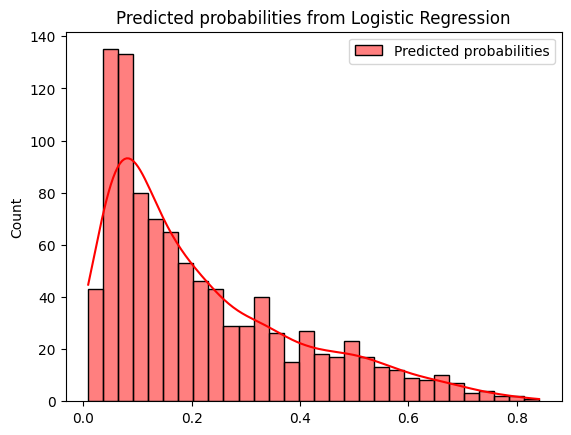

In [39]:
sns.histplot(y_pred_proba, bins=30, kde=True, color='red', label='Predicted probabilities')
plt.title("Predicted probabilities from Logistic Regression")
plt.legend()
plt.show()

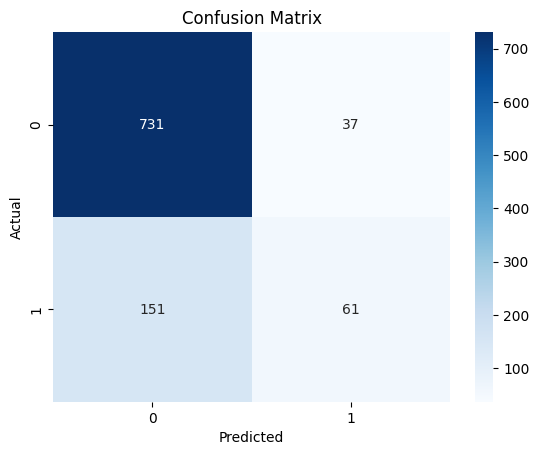

In [40]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [41]:
with open('../Training-models/Model/log_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [45]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Neha")

    mlflow.log_param("train_val_data_path", "../Training-models/Data/winequality-red.csv")
    mlflow.log_param("train_val_data_path2", "../Training-models/Data/winequality-white.csv")

    alpha = 1.0
    mlflow.log_param("alpha", alpha)

    ridge = RidgeClassifier(alpha)
    ridge.fit(X_train, y_train)

    y_pred_ridge = ridge.predict(X_val)

    acc_ridge = accuracy_score(y_val, y_pred_ridge)
    mlflow.log_metric("acc", acc)
    print("\nRidge Classifier Accuracy:", acc_ridge)


Ridge Classifier Accuracy: 0.8040816326530612



Lasso RMSE: 0.39241787461614885


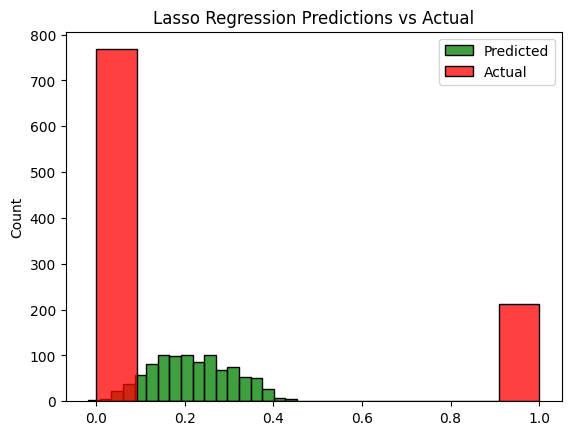

In [43]:
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred_lasso)

print("\nLasso RMSE:", rmse)

sns.histplot(y_pred_lasso, color='green', label='Predicted')
sns.histplot(y_val, color='red', label='Actual')
plt.legend()
plt.title("Lasso Regression Predictions vs Actual")
plt.show()

In [47]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    log_loss
)


In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 3, 12, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

In [50]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")

        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        y_pred_prob = booster.predict(valid)
        y_pred = (y_pred_prob > 0.5).astype(int)

        auc = roc_auc_score(y_val, y_pred_prob)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        logloss_val = log_loss(y_val, y_pred_prob)

        mlflow.log_metric("auc", auc)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("logloss", logloss_val)

        # Optionally log classification report as a text artifact
        report = classification_report(y_val, y_pred, output_dict=False)
        with open("classification_report.txt", "w") as f:
            f.write(report)

        mlflow.log_artifact("classification_report.txt")

    return {'loss': logloss_val, 'status': STATUS_OK}


In [51]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

print("Best hyperparameters:", best_result)


100%|██████████| 50/50 [00:16<00:00,  2.95trial/s, best loss: 0.27018025618428687]
Best hyperparameters: {'learning_rate': np.float64(0.05014112907771602), 'max_depth': np.float64(10.0), 'min_child_weight': np.float64(1.9784330400235082), 'reg_alpha': np.float64(0.08792049201961026), 'reg_lambda': np.float64(0.04979507632301252)}


In [52]:
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

mlflow.sklearn.autolog()

models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier(),
    LogisticRegression(),
    SVC(probability=True)
]

for model in models:
    with mlflow.start_run():
        mlflow.set_tag("model", type(model).__name__)
        
        mlmodel = model
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        y_pred_prob = mlmodel.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred_prob)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        mlflow.log_metric("auc", auc)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)

        report = classification_report(y_val, y_pred, output_dict=False)
        with open("classification_report.txt", "w") as f:
            f.write(report)

        mlflow.log_artifact("classification_report.txt")


/home/codespace/anaconda3/envs/exp-track-new/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/anaconda3/envs/exp-track-new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/anaconda3/